# Atividade - Perceptron Multiclasse

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def CriaDataSetClassificacao(n=20, slop=[2,1], intercept=-0.4): 
    #exemplo 1
    #slop=[2,1], intercept=-0.4

    X = np.random.uniform(size=(n,2))
    AUX = np.multiply(X,slop)-[0, intercept]
    y = (AUX[:,0] > X[:,1])*2-1
    
    return X, y

def CriaDataSetRegressao(n=20, slop=0.5, intercept=0.2): 
    #função atualizada na AULA 2
    #exemplo com regressão e apenas uma dimensão
    X = np.random.uniform(size=(n,1)) #n,1 apenas uma dimensão
    AUX = np.random.rand(n,1)-0.5
    
    y = X*slop + intercept + AUX*0.1
    y = y.flatten()
    
    return X, y
    
def CriaDataSetRegularizacao(n=20, slop=[2,1], intercept=-0.4, dummy_features=3): 
    '''
    Dataset para ilustrar regularização no treinamento.
    Criaremos uma base que possui algum ruído proposital para avaliar o comportamento do treinamento com ele.
    '''
    
    X = np.random.uniform(size=(n,dummy_features))
    AUX = np.multiply(X[:,:2],slop)-[0, intercept] # equivalente @, multiplicação de matrizes
    y = np.array(AUX[:,0] > AUX[:,1], dtype=int)*2-1
    
    return X, y

def criaDatasetMulticlasse(n=1000,n_classes=4):
    '''
    Gera uma base de dados para problemas multiclasse (n_classes conforme parâmetro).
    '''
    X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1),cluster_std=0.02)
    return X,y

def criaDatasetXOR(n=1000):
    '''
    Cria dataset XOR, não linearmente separável.
    Será necessária uma camada oculta para resolver. Próxima aula
    '''
    X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
    y = np.array(y%2,dtype=int)
    return X,y

In [76]:
def plotDataSet(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    for k in set(y):
        #print("k=",k)
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o",alpha=0.3)

def plotDatasetRegressao(X, y):
    '''
    Função para plotar o dataset para a regressão, pois difere devido a apenas
    uma dimensão do X.
    '''
    
    plt.plot(X[:,0], y, "o", alpha=0.3)

def plotHiperplano(X,y,vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    
    xs = np.linspace(x0min, x0max, num=2)
    #separador do hiperplano entre duas classificações pode ser 
    #encontrada conforme calculo abaixo:
    ys = (-vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.plot(xs,ys)

def PlotCusto(custos):
    '''
    Plotando o gráfico de iterações x custo para aprendizado.
    '''
    if (len(custos) == 0):
        print('ERRO: Modelo ainda não treinado para avaliar o custo!')
        return
    
    x = [i for i in range(1,len(custos) + 1)]

    plt.xlabel('Nº Iterações')
    plt.ylabel('Custo')
    plt.plot(x, custos, "-")
    plt.show()

### Classes de Custo

In [77]:
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod, abstractstaticmethod
import random

class Custo(ABC):
    '''
    Classe de custo
    '''
    @abstractstaticmethod
    def custo(self, y, ypred):
        pass

    @abstractstaticmethod
    def gradiente(self, y, ypred):
        pass

In [78]:
from scipy.special import expit

class WidrowHoff(Custo):
    '''
    Função de custo sofre com a distância de pontos distantes do hiperplano.
    Quem está distante influencia o coeficiente final.
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum((y - ypred)**2)
    
    @staticmethod
    def gradiente(y, ypred):
        return y - ypred

class SmoothedSurrogate(Custo):
    '''
    Função de custo cujo gradiente utiliza o mesmo método do PLA Perseptron inicial (Aula1), mas
    a função de custo é calculada de forma diferente.

    custo = - y * ypred
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), -y*ypred))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - sign(ypred)

class LogLikehood(Custo):
    '''
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(-y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - (expit(ypred)*2-1)

class HingeLoss(Custo):
    '''
    Função de custo tende a considerar quem está mais próximo do hiperplano.
    custo -> 1 - y * ypred
    gradiente -> considera os erros negativos com maior rigor que os positivos, de forma a penalizar
    o algoritmo quando erra muito negativamente (errosmarginais) 
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - (y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        #filtro para encontrar os erros marginais
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        
        #zerando todos os erros que não são marginais
        #invertendo os indices, 
        ymarginais[~errosmarginais] = 0 

        return ymarginais


## Definição do Perceptron

In [79]:
def sign(a):
    return (a >= 0)*2-1

def accuracy(yactual, ypred):
    return sum(yactual==ypred)/len(yactual)

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y):
        pass
             
class DescidaGradiente(TrainingAlgorithm):
    def __init__(self,max_iter=100,learning_rate=0.02, regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        
        #evitar overfiting. Funciona como uma "taxa de esquecimento" no aprendizado
        #quanto maior a regularização, mais esquecimento do w anterior eu tenho na nova iteração
        self.regularization = regularization
        self.cost = cost
        self.custos = []

    def getW(self,X,y):
        """
        getW com alterações para PerceptronMulticlasse
        """
        w =np.random.uniform(-1,1,size=(X.shape[1],y.shape[1])) #começa com um vetor de pesos aleatórios
        for _ in range(self.max_iter):
            ypred = X @ w
            c = self.cost.custo(y, ypred) 
            self.custos.append(c)
            if c==0:
                break
            w *= 1-self.regularization*self.learning_rate
            w += (X.T @ self.cost.gradiente(y, ypred))*self.learning_rate
        return w


# Atividade - Perceptron Multiclasse

Implemente uma Rede Neural rasa para classificação de uma base multiclasse.

Esta rede deve:

<ol>
<li>Aceitar rótulos que podem ser números ou textos;
<li>Predizer os rótulos originais da base de dados;
<li>Passar por parâmetro no construtor:
    <ol>
        <li>Função de custo e cálculo do gradiente;
        <li>Taxa de aprendizado;
        <li>Número máximo de iterações;
        <li>Threshold;
    </ol>
<li>
</ol>

Teste pelo menos duas funções de custo diferentes em uma base multiclasse e uma base binária.

Plote gráficos com os hiperplanos separadores encontrados pelos algoritmos de treinamento. Se a base escolhida tiver mais do que 2 características, escolha as que você julgar que fornecem a melhor visualização.

### Perceptron Multiclasse

In [80]:
from sklearn.preprocessing import label_binarize

class PerceptronMulticlasse(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
          
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb
        
    def predict(self, X, y=None):
        Xb = self.includeBias(X)
        a = Xb @ self.w
        
        if self.w.shape[1]==1: 
            idx = np.array(a>0,dtype=int).reshape((-1,)) #problema de 2 classes
        else:
            idx = np.argmax(a,axis=1)
        ypred = np.array([self.labels[i] for i in idx]) #pega a coluna de maior probabilidade
        return ypred
    
    def fit(self, X, y):
        yhot = self.encode_labels(y) #não usar as classes qdo o problema é multiclasse, fazer o one-hot-encode
        Xb = PerceptronMulticlasse.includeBias(X) #essas duas linhas são pre tratamentos
        self.w = self.training_algorithm.getW(Xb,yhot)

    def encode_labels(self,y):
        self.labels = list(set(y))
        return label_binarize(y,classes=self.labels)*2-1 

In [106]:
#criando uma base de dados para testes

from sklearn.model_selection import train_test_split

#criando um dataset
X,y = criaDatasetMulticlasse()
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)

### LogLikehood

1.0


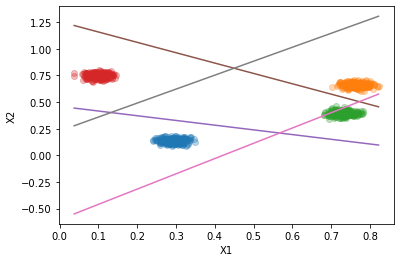

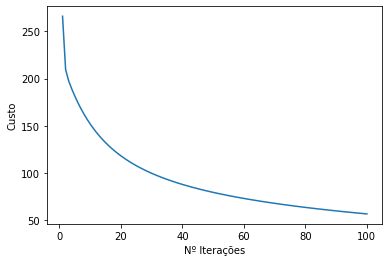

In [107]:
#exemplo de PerceptronMulticlasse

percep = PerceptronMulticlasse(DescidaGradiente(cost=LogLikehood()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataSet(X, y)

if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

A função de custo também pode variar, conforme o Perceptron 'padrão'. Porém, a função LogLikehood oferece o mesmo resultado da Softamx.
Também é possível utilizar a HingeLoss, mas para problemas multiclasse a Sofmax é melhor.

### HingeLoss

1.0


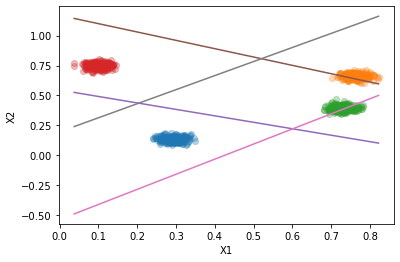

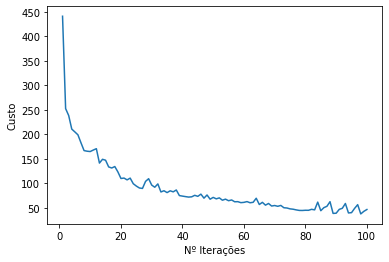

In [108]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=HingeLoss()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataSet(X, y)

#plotHiperplano(X,y,percep.w[1:], percep.w[0])
if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

### SmoothedSurrogate

1.0


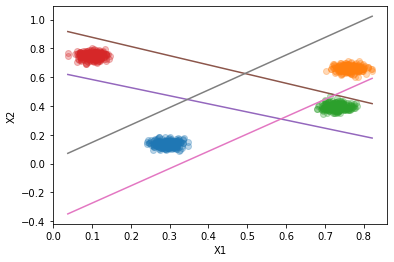

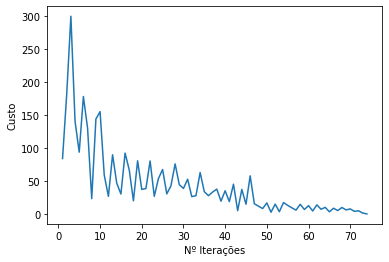

In [109]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=SmoothedSurrogate()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataSet(X, y)

if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

# Testes - Base Binária

Para base binária, basta utilizar a mesma função que criamos que gara o dataset passando 2 no parâmetro de classes.

In [110]:
X,y = criaDatasetMulticlasse(n_classes=2)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)


## Perceptron Multiclasse: base binária + HingeLoss

0.49666666666666665


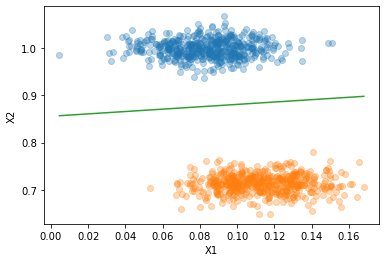

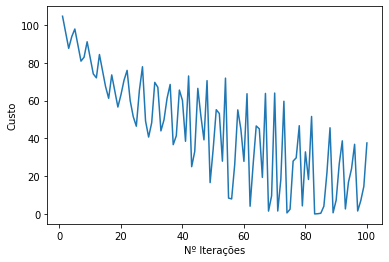

In [111]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=HingeLoss()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataSet(X, y)

if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

## Perceptron Multiclasse: base binária + LogLikehood

0.49666666666666665


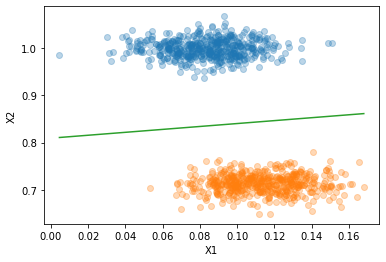

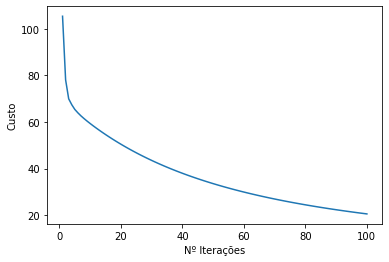

In [112]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=LogLikehood()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataSet(X, y)

if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

Abaixo, iremos redefinir a função de 'predict' do PerceptronMulticlasse.

In [113]:
from sklearn.preprocessing import label_binarize

class PerceptronMulticlasse(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
          
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb
        
    def predict(self, X, y=None):
        Xb = self.includeBias(X)
        a = Xb @ self.w
        
        #>>> ALTERAÇÃO DA DEFINIÇÂO ANTERIOR <<<
        idx = np.argmax(a,axis=1) 
        ypred = np.array([self.labels[i] for i in idx])

        return ypred
    
    def fit(self, X, y):
        yhot = self.encode_labels(y) #não usar as classes qdo o problema é multiclasse, fazer o one-hot-encode
        Xb = PerceptronMulticlasse.includeBias(X) #essas duas linhas são pre tratamentos
        self.w = self.training_algorithm.getW(Xb,yhot)

    def encode_labels(self,y):
        self.labels = list(set(y))
        return label_binarize(y,classes=self.labels)*2-1 

0.49666666666666665


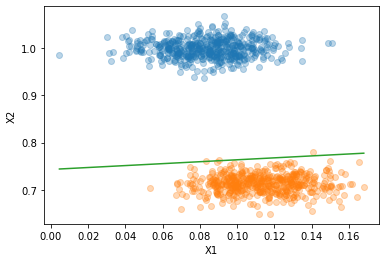

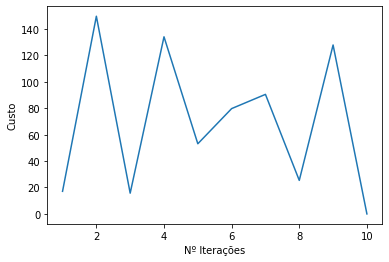

In [114]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=SmoothedSurrogate()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataSet(X, y)

if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)